In [1]:
import os
import re
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

%run ../env.py
%run ../src/lib.py
%run src/protein_tokenization.py

In [2]:
df_tag = pd.read_csv(osp.join(DATA_DIR, 'articles', 'corpus', 'corpus_01', 'tags-union.csv'))
pd.set_option('display.max_info_rows', 10000000)
df_tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310512 entries, 0 to 2310511
Data columns (total 11 columns):
end_chr       2310512 non-null int64
end_wrd       2310512 non-null int64
ent_id        961277 non-null object
ent_lbl       961277 non-null object
ent_prefid    961277 non-null object
ent_src       2310512 non-null object
id            2310512 non-null object
start_chr     2310512 non-null int64
start_wrd     2310512 non-null int64
text          2310512 non-null object
type          2310512 non-null object
dtypes: int64(4), object(7)
memory usage: 193.9+ MB


In [3]:
df_tag['ent_src'].value_counts()

jnlpba    1349235
lkp        961277
Name: ent_src, dtype: int64

In [4]:
df_tag.head()

,end_chr,end_wrd,ent_id,ent_lbl,ent_prefid,ent_src,id,start_chr,start_wrd,text,type
0,828,148,NaN,NaN,NaN,jnlpba,PMC100031,821,146,B cells,CELL_TYPE
1,957,170,NaN,NaN,NaN,jnlpba,PMC100031,912,165,immunoglobulin M (IgM)-secreting spleen cells,CELL_TYPE
2,1012,181,NaN,NaN,NaN,jnlpba,PMC100031,991,178,IgM-secreting B cells,CELL_TYPE
3,1375,239,NaN,NaN,NaN,jnlpba,PMC100031,1340,236,non-parasite-directed B-cell clones,CELL_LINE
4,1697,292,NaN,NaN,NaN,jnlpba,PMC100031,1684,288,B and T cells,CELL_TYPE


In [5]:
df_tag[df_tag['id'] == 'PMC5704053'].pipe(lambda df: df[df['text'] == 'TCM'])

,end_chr,end_wrd,ent_id,ent_lbl,ent_prefid,ent_src,id,start_chr,start_wrd,text,type
1727598,3299,596,NaN,NaN,NaN,jnlpba,PMC5704053,3296,595,TCM,CELL_TYPE
1727796,3299,596,CT6DE81C14BBB65271,TCM,CT143F3E7366C9650A,lkp,PMC5704053,3296,595,TCM,IMMUNE_CELL_TYPE


In [109]:
(df_tag['text'].str.contains('T') & (df_tag['ent_src'] == 'jnlpba')).value_counts()

False    1775014
True      535498
dtype: int64

In [78]:
df_tag[df_tag['ent_src'] == 'lkp']['type'].value_counts()

CYTOKINE                485040
IMMUNE_CELL_TYPE        314554
TRANSCRIPTION_FACTOR    161683
Name: type, dtype: int64

In [22]:
NORM_REGEX = re.compile(r'(-cells|-cell| cells| cell|-lymphocytes|-lymphocyte| lymphocytes| lymphocyte)', flags=re.I)

def normalize_noun_phrase(t):
    return NORM_REGEX.sub('', t).strip()

In [79]:
import interlap

def get_paired_mentions(g):
    df1 = g[(g['ent_src'] == 'jnlpba') & (g['type'].isin(['CELL_TYPE', 'CELL_LINE']))]
    df2 = g[(g['ent_src'] == 'lkp') & (g['type'] == 'IMMUNE_CELL_TYPE')]
    
    rngs = interlap.InterLap()
    for _, r in df1.iterrows():
        rngs.add((r['start_wrd'], r['end_wrd'], r))
        
    df = []
    for i, r in df2.iterrows():
        matches = [
            o[-1][['id', 'start_wrd', 'end_wrd', 'type', 'text']].to_dict()
            for o in rngs.find((r.start_wrd, r.start_wrd))    
        ]
        for m in matches:
            # Ignore matches that are roughly equal from both sources (e.g. 'Th1 cells' == 'Th1')
            if normalize_noun_phrase(m['text']) != r['text']:
                # Add jnlpba row with extra data for corresponding lookup match
                df.append({**m, **{'match_prefid': r['ent_prefid'], 'match_lbl': r['ent_lbl'], 'match_text': r['text']}})
    return pd.DataFrame(df)
        
def get_cell_type_tags(df):
    res = []
    grps = df.groupby('id')
    for k, g in tqdm.tqdm(grps, total=len(grps)):
        res.append(get_paired_mentions(g))
    return pd.concat(res)
    

df_ct = (
    df_tag
    .pipe(lambda df: df[df['text'].str.contains('T')])
    #.pipe(lambda df: df[df['id'] == 'PMC5704053'])
    .pipe(get_cell_type_tags)
)
df_ct.info()

100%|██████████| 9392/9392 [06:33<00:00, 23.85it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 85463 entries, 0 to 1
Data columns (total 8 columns):
end_wrd         85463 non-null int64
id              85463 non-null object
match_lbl       85463 non-null object
match_prefid    85463 non-null object
match_text      85463 non-null object
start_wrd       85463 non-null int64
text            85463 non-null object
type            85463 non-null object
dtypes: int64(2), object(6)
memory usage: 5.9+ MB


In [80]:
df_ct.head()

,end_wrd,id,match_lbl,match_prefid,match_text,start_wrd,text,type
0,111,PMC102037,Tc,CT231C4EC31B01615E,cytotoxic T,107,Gag-specific cytotoxic T lymphocytes,CELL_TYPE
0,19,PMC103836,Th,CTB7DFCED683E6F0A9,T-Helper,12,Cytokine-Induced CD4+ T-Helper 1 (Th1)-,CELL_LINE
1,59,PMC103836,Th,CTB7DFCED683E6F0A9,T-helper,51,T-helper 1 (Th1) or Th2 cells,CELL_TYPE
2,59,PMC103836,Th1,CTC3A8C3CBC245616A,Th1,51,T-helper 1 (Th1) or Th2 cells,CELL_TYPE
3,59,PMC103836,Th2,CTE7B12DC660323A0E,Th2,51,T-helper 1 (Th1) or Th2 cells,CELL_TYPE


In [81]:
df_ct_grp = df_ct.groupby(['id', 'start_wrd', 'end_wrd', 'text']).agg({'match_lbl': 'unique', 'match_text': 'unique'}).reset_index()
df_ct_grp.head()

,id,start_wrd,end_wrd,text,match_lbl,match_text
0,PMC102037,107,111,Gag-specific cytotoxic T lymphocytes,[Tc],[cytotoxic T]
1,PMC103836,12,19,Cytokine-Induced CD4+ T-Helper 1 (Th1)-,[Th],[T-Helper]
2,PMC103836,51,59,T-helper 1 (Th1) or Th2 cells,"[Th, Th1, Th2]","[T-helper, Th1, Th2]"
3,PMC103836,226,230,Th1 or Th2 cells,"[Th1, Th2]","[Th1, Th2]"
4,PMC104278,48,53,CD4+ Th2 and Th0,"[Th2, Th0]","[Th2, Th0]"


In [82]:
df_ct_tgt = df_ct_grp[df_ct_grp['match_lbl'].apply(len) == 1].copy()
df_ct_tgt['match_lbl'] = df_ct_tgt['match_lbl'].apply(lambda v: v[0])
df_ct_tgt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59500 entries, 0 to 69239
Data columns (total 6 columns):
id            59500 non-null object
start_wrd     59500 non-null int64
end_wrd       59500 non-null int64
text          59500 non-null object
match_lbl     59500 non-null object
match_text    59500 non-null object
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In [83]:
df_ct_tgt.head()

,id,start_wrd,end_wrd,text,match_lbl,match_text
0,PMC102037,107,111,Gag-specific cytotoxic T lymphocytes,Tc,[cytotoxic T]
1,PMC103836,12,19,Cytokine-Induced CD4+ T-Helper 1 (Th1)-,Th,[T-Helper]
9,PMC1064915,193,202,T helper 1 (Th1) polarized effector cells,Th1,"[T helper 1, Th1]"
12,PMC108035,256,262,cytotoxic T (Tc1/Tc2) cells,Tc,[cytotoxic T]
13,PMC108135,87,97,"CD4+, CD8+, and γδ T cells",γδT,[γδ T]


### Initialize Tokenizer

In [151]:
df_pro = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'raw', 'pro.raw.csv'))

# Get groups and parents for CD molecules
tgt_ids = list(df_pro[df_pro['syn'].fillna('').str.startswith('CD')]['id'].unique())
tgt_ids = np.unique(list(df_pro.set_index('id').loc[tgt_ids]['parent'].unique()) + tgt_ids)
df_pro = (
    df_pro
    .pipe(lambda df: df[df['species'].isin(['human', 'any'])])
    .pipe(lambda df: df[df['syn'].str.len() >= 3])
    .pipe(lambda df: df[(~df['syn'].str.contains(' ')) | (df['syn_typ'] == 'label')])
    .pipe(lambda df: df[df['id'].isin(tgt_ids)])
    # REMOVE after next PRO import
    .assign(syn=lambda df: df['syn'].str.replace(r'\(({})\)'.format('|'.join(list(df['species'].unique()))), ''))
    # Remove synonyms like "hCFAP299/iso:h1"
    .pipe(lambda df: df[~df['syn'].str.contains('/|:')])
)

df_pro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5813 entries, 7111 to 628148
Data columns (total 11 columns):
category      5795 non-null object
id            5813 non-null object
label         5813 non-null object
name          5813 non-null object
namespace     5813 non-null object
parent        5433 non-null object
syn           5813 non-null object
syn_typ       5813 non-null object
species       5813 non-null object
syn_typ_id    5813 non-null int64
species_id    5813 non-null int64
dtypes: int64(2), object(9)
memory usage: 545.0+ KB


In [149]:
df_pro.head()

,category,id,label,name,namespace,parent,syn,syn_typ,species,syn_typ_id,species_id
1412,gene,PR:000015306,histone-lysine N-methyltransferase SMYD1,PR_000015306,obo,PR:000015306,zinc finger protein BOP,exact,any,2,3
3249,organism-gene,PR:Q9ULV3,Cip1-interacting zinc finger protein (human),PR_Q9ULV3,obo,PR:000005508,zinc finger protein 356,exact,human,2,2
3250,gene,PR:000005508,Cip1-interacting zinc finger protein,PR_000005508,obo,PR:000005508,zinc finger protein 356,exact,any,2,3
7111,organism-gene,PR:P64554,7-carboxy-7-deazaguanine synthase (Escherichia...,PR_P64554,obo,PR:000034945,ygcF,related,any,1,3
7117,organism-gene,PR:Q46893,2-C-methyl-D-erythritol 4-phosphate cytidylylt...,PR_Q46893,obo,PR:000023036,ygbP,related,any,1,3


In [153]:
pm_pro = df_pro[df_pro['syn_typ'] == 'label'].set_index('id')[['label']].to_dict(orient='index')
df_tf = get_entity_meta_data(TRANSCRIPTION_FACTORS)
pm_tf = df_tf.set_index('id')[['lbl']].to_dict(orient='index')
df_ck = get_entity_meta_data(CYTOKINES)
pm_ck = df_ck.set_index('id')[['lbl']].to_dict(orient='index')
vocab = {
    **{r['syn']: (r['label'], r['id'], pm_pro.get(r['parent'], {}).get('label'), r['parent'], 'pr') for i, r in df_pro.iterrows()},
    **{r['sym']: (r['lbl'], r['id'], pm_tf.get(r['prefid'], {}).get('lbl'), r['prefid'], 'tf') for i, r in df_tf.iterrows()},
    **{r['sym']: (r['lbl'], r['id'], pm_ck.get(r['prefid'], {}).get('lbl'), r['prefid'], 'ck') for i, r in df_ck.iterrows()}
}

In [154]:
len(vocab)

19498

In [155]:
#df_pro[df_pro['id'] == 'PR:000005175']

In [162]:
tokenizer = ProteinTokenizer(vocab)
#string = 'CD4+CD45RA+CD45RO-4-1BB-CD62L+++CCR7loCD127posCD27positiveCD28hiCD95+CD122+'
string = 'CD4+Thy1.1+CD44hiLy6chiPSGL-1hi'

In [163]:
for t in tokenizer.tokenize(string):
    print(f'{t.text} [term={t.token_text}, sign={t.sign_text}, value={t.sign_value}, metadata={t.metadata}]')

CD4+ [term=CD4, sign=+, value=1, metadata=('CD4', 'CK216B03A5814616B8', 'CD4', 'CK216B03A5814616B8', 'ck')]
Thy1.1 [term=Thy1.1, sign=None, value=0, metadata=None]
CD44hi [term=CD44, sign=hi, value=1, metadata=('CD44 molecule', 'PR:000001307', 'CD44 molecule', 'PR:000001307', 'pr')]
Ly6c [term=Ly6c, sign=None, value=0, metadata=None]
PSGL-1hi [term=PSGL-1, sign=hi, value=1, metadata=('P-selectin glycoprotein ligand 1', 'PR:000001830', 'P-selectin glycoprotein ligand 1', 'PR:000001830', 'pr')]


### Retokenize

In [164]:
df_ct_tgt.head()

,id,start_wrd,end_wrd,text,match_lbl,match_text,prs
0,PMC102037,107,111,Gag-specific cytotoxic T lymphocytes,Tc,[cytotoxic T],[ifi]
1,PMC103836,12,19,Cytokine-Induced CD4+ T-Helper 1 (Th1)-,Th,[T-Helper],[CD4⁺(+)]
9,PMC1064915,193,202,T helper 1 (Th1) polarized effector cells,Th1,"[T helper 1, Th1]",[]
12,PMC108035,256,262,cytotoxic T (Tc1/Tc2) cells,Tc,[cytotoxic T],[]
13,PMC108135,87,97,"CD4+, CD8+, and γδ T cells",γδT,[γδ T],[CD4⁺(+)]


In [165]:
len(df_ct_tgt)

59500

In [166]:
def get_proteins(r):
    return [
        t
        for w in re.split(r'\s+', r['text'])
        for t in tokenizer.tokenize(w)
        if t.metadata is not None
    ]

df_ct_tgt['prs'] = [get_proteins(r) for _, r in tqdm.tqdm(df_ct_tgt.iterrows(), total=len(df_ct_tgt))]

100%|██████████| 59500/59500 [24:10<00:00, 41.01it/s]


In [170]:
df_ct_tgt.head()

,id,start_wrd,end_wrd,text,match_lbl,match_text,prs
0,PMC102037,107,111,Gag-specific cytotoxic T lymphocytes,Tc,[cytotoxic T],[ifi]
1,PMC103836,12,19,Cytokine-Induced CD4+ T-Helper 1 (Th1)-,Th,[T-Helper],[CD4⁺(+)]
9,PMC1064915,193,202,T helper 1 (Th1) polarized effector cells,Th1,"[T helper 1, Th1]",[]
12,PMC108035,256,262,cytotoxic T (Tc1/Tc2) cells,Tc,[cytotoxic T],[]
13,PMC108135,87,97,"CD4+, CD8+, and γδ T cells",γδT,[γδ T],[CD4⁺(+)]


In [171]:
df_ct_tgt[df_ct_tgt['prs'].apply(len) > 1].head(15)

,id,start_wrd,end_wrd,text,match_lbl,match_text,prs
18,PMC110037,246,252,virus-specific CD4+CD8+ memory T lymphocytes,TMEM,[memory T],"[ifi, CD4⁺(+)]"
23,PMC110189,171,175,LCMV-specific CD4 Th1 cells,Th1,[Th1],"[ifi, CD4]"
37,PMC1159133,40,43,CD4+CD25+ Tregs,Treg,[Tregs],"[CD4⁺(+), CD25⁺(+)]"
38,PMC1159133,68,73,peripheral CD4+CD25+ Treg populations,Treg,[Treg],"[CD4⁺(+), CD25⁺(+)]"
71,PMC128930,1071,1078,CD4+ CD25+ regulatory T cells,Treg,[regulatory T],"[CD4⁺(+), CD25⁺(+)]"
92,PMC1323501,7157,7165,gp120-specific CD8+ CTL and CD4+ Th,Th,[Th],"[ifi, CD4⁺(+)]"
93,PMC1323501,7600,7605,HIV Env-specific CD4+ Th,Th,[Th],"[ifi, CD4⁺(+)]"
214,PMC1555646,196,200,human CD4+CD25+Foxp3+ Tregs,Treg,[Tregs],"[CD4⁺(+), CD25⁺(+)]"
256,PMC1762372,214,226,"neonatal CD4+, adult CD4+, and adult CD4− NKT",NKT,[NKT],"[CD4⁺(+), CD4⁺(+), CD4⁻(−)]"
267,PMC1762372,606,613,human CD4+ and CD4− NKT cells,NKT,[NKT],"[CD4⁺(+), CD4⁻(−)]"


In [172]:
t = df_ct_tgt['prs'].iloc[0][0]
t.metadata, t.text, t.sign_value

(('IFN-γ', 'CKCE1EE63C15FF125E', 'IFN-γ', 'CKEF3883BE9F74024F', 'ck'),
 'ifi',
 0)

In [173]:
df_ct_cts = pd.DataFrame([
    dict(
        id=r['id'], start_wrd=r['start_wrd'], end_wrd=r['end_wrd'], text=r['text'], match_lbl=r['match_lbl'], 
        pr_lbl=t.metadata[0], pr_id=t.metadata[1], pr_preflbl=t.metadata[2], 
        pr_prefid=t.metadata[3], pr_typ=t.metadata[4], pr_sign=t.sign_value
    )
    for i, r in df_ct_tgt.iterrows()
    for t in r['prs']
])
df_ct_cts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27140 entries, 0 to 27139
Data columns (total 11 columns):
end_wrd       27140 non-null int64
id            27140 non-null object
match_lbl     27140 non-null object
pr_id         27140 non-null object
pr_lbl        27140 non-null object
pr_prefid     27121 non-null object
pr_preflbl    27093 non-null object
pr_sign       27140 non-null int64
pr_typ        27140 non-null object
start_wrd     27140 non-null int64
text          27140 non-null object
dtypes: int64(3), object(8)
memory usage: 2.3+ MB


In [174]:
df_ct_cts.head()

,end_wrd,id,match_lbl,pr_id,pr_lbl,pr_prefid,pr_preflbl,pr_sign,pr_typ,start_wrd,text
0,111,PMC102037,Tc,CKCE1EE63C15FF125E,IFN-γ,CKEF3883BE9F74024F,IFN-γ,0,ck,107,Gag-specific cytotoxic T lymphocytes
1,19,PMC103836,Th,CK216B03A5814616B8,CD4,CK216B03A5814616B8,CD4,1,ck,12,Cytokine-Induced CD4+ T-Helper 1 (Th1)-
2,97,PMC108135,γδT,CK216B03A5814616B8,CD4,CK216B03A5814616B8,CD4,1,ck,87,"CD4+, CD8+, and γδ T cells"
3,50,PMC108744,Tc,CKCE1EE63C15FF125E,IFN-γ,CKEF3883BE9F74024F,IFN-γ,0,ck,46,peptide-specific cytotoxic T lymphocytes
4,11,PMC110037,Th,CK216B03A5814616B8,CD4,CK216B03A5814616B8,CD4,1,ck,5,Extrathymic CD4+CD8+ Memory T-Helper Cells


In [175]:
df_ct_cts['match_lbl'].unique()

array(['Tc', 'Th', 'γδT', 'TMEM', 'Th1', 'Treg', 'Th2', 'TEM', 'TN',
       'NKT', 'nTreg', 'Thymocyte', 'Th17', 'TCM', 'Tc1', 'Th0', 'ThP',
       'iTreg', 'Treg1', 'Tfh', 'TEMRA', 'pTreg', 'Th22', 'γδT-Vγ9Vδ2',
       'γδT-Vγ4', 'Tc17', 'Th3', 'Tscm', 'Treg17', 'γδT-Vδ2', 'γδT-Vδ1',
       'Th9', 'Trm', 'Tc0', 'Tc9', 'MAIT', 'Tfreg', 'Tc2', 'γδT-17',
       'DETC', 'Tfh17like'], dtype=object)

In [176]:
import plotnine as pn

In [180]:
#df_pro[df_pro['id'] == 'PR:000001207']
vocab['CXCR3']

('CXCR3', 'CK793538E09E318364', 'CXCR3', 'CK793538E09E318364', 'ck')

In [206]:
df_ct_cts[df_ct_cts['match_lbl'] == 'Tc17'].head(15)

,end_wrd,id,match_lbl,pr_id,pr_lbl,pr_prefid,pr_preflbl,pr_sign,pr_typ,start_wrd,text
4360,131,PMC3329547,Tc17,CKCE1EE63C15FF125E,IFN-γ,CKEF3883BE9F74024F,IFN-γ,0,ck,128,antigen-specific Tc17 cells
4361,1247,PMC3329547,Tc17,CKFA53DC58D6564572,IL-17a,CK7E93E453FF75508D,IL-17a,0,ck,1244,IL-17-positive Tc17 cells
4362,2538,PMC3329547,Tc17,CKCE1EE63C15FF125E,IFN-γ,CKEF3883BE9F74024F,IFN-γ,0,ck,2535,virus-specific Tc17 cells
4363,2787,PMC3329547,Tc17,CKCE1EE63C15FF125E,IFN-γ,CKEF3883BE9F74024F,IFN-γ,0,ck,2783,vitro-derived Ag-specific Tc17 cells
4365,3008,PMC3329547,Tc17,CK1B71668FDDECE3CF,IFN-γ,CKEF3883BE9F74024F,IFN-γ,0,ck,3004,IFN-γ positive Tc17 cells
4984,985,PMC3400565,Tc17,CKCE1EE63C15FF125E,IFN-γ,CKEF3883BE9F74024F,IFN-γ,0,ck,982,antigen-specific Tc17 cells
4985,1466,PMC3400565,Tc17,CKCE1EE63C15FF125E,IFN-γ,CKEF3883BE9F74024F,IFN-γ,0,ck,1461,polyclonal and yeast-specific Tc17 cells
4986,1765,PMC3400565,Tc17,CKCE1EE63C15FF125E,IFN-γ,CKEF3883BE9F74024F,IFN-γ,0,ck,1762,fungal-specific Tc17 cells
6599,773,PMC3657121,Tc17,CKFA53DC58D6564572,IL-17a,CK7E93E453FF75508D,IL-17a,-1,ck,765,IL-17-producing CD8+ T (Tc17) cells
7425,203,PMC3800609,Tc17,CKFA53DC58D6564572,IL-17a,CK7E93E453FF75508D,IL-17a,-1,ck,200,IL-17-producing Tc17 cells


In [205]:
vocab['TC1'] # Fix this

('CXCL7', 'CK8263ED0D128A2F51', 'CXCL7', 'CK06352AD1E10C88B6', 'ck')

In [207]:
vocab['BCL6']

('BCL6', 'TFA2BE078899C686C3', 'BCL6', 'TFA2BE078899C686C3', 'tf')

In [192]:
for t in tokenizer.tokenize('Hmgb1−/−'):
    print(t.text, t.sign_value, t.metadata)

Hmgb1 0 None
/ 0 None


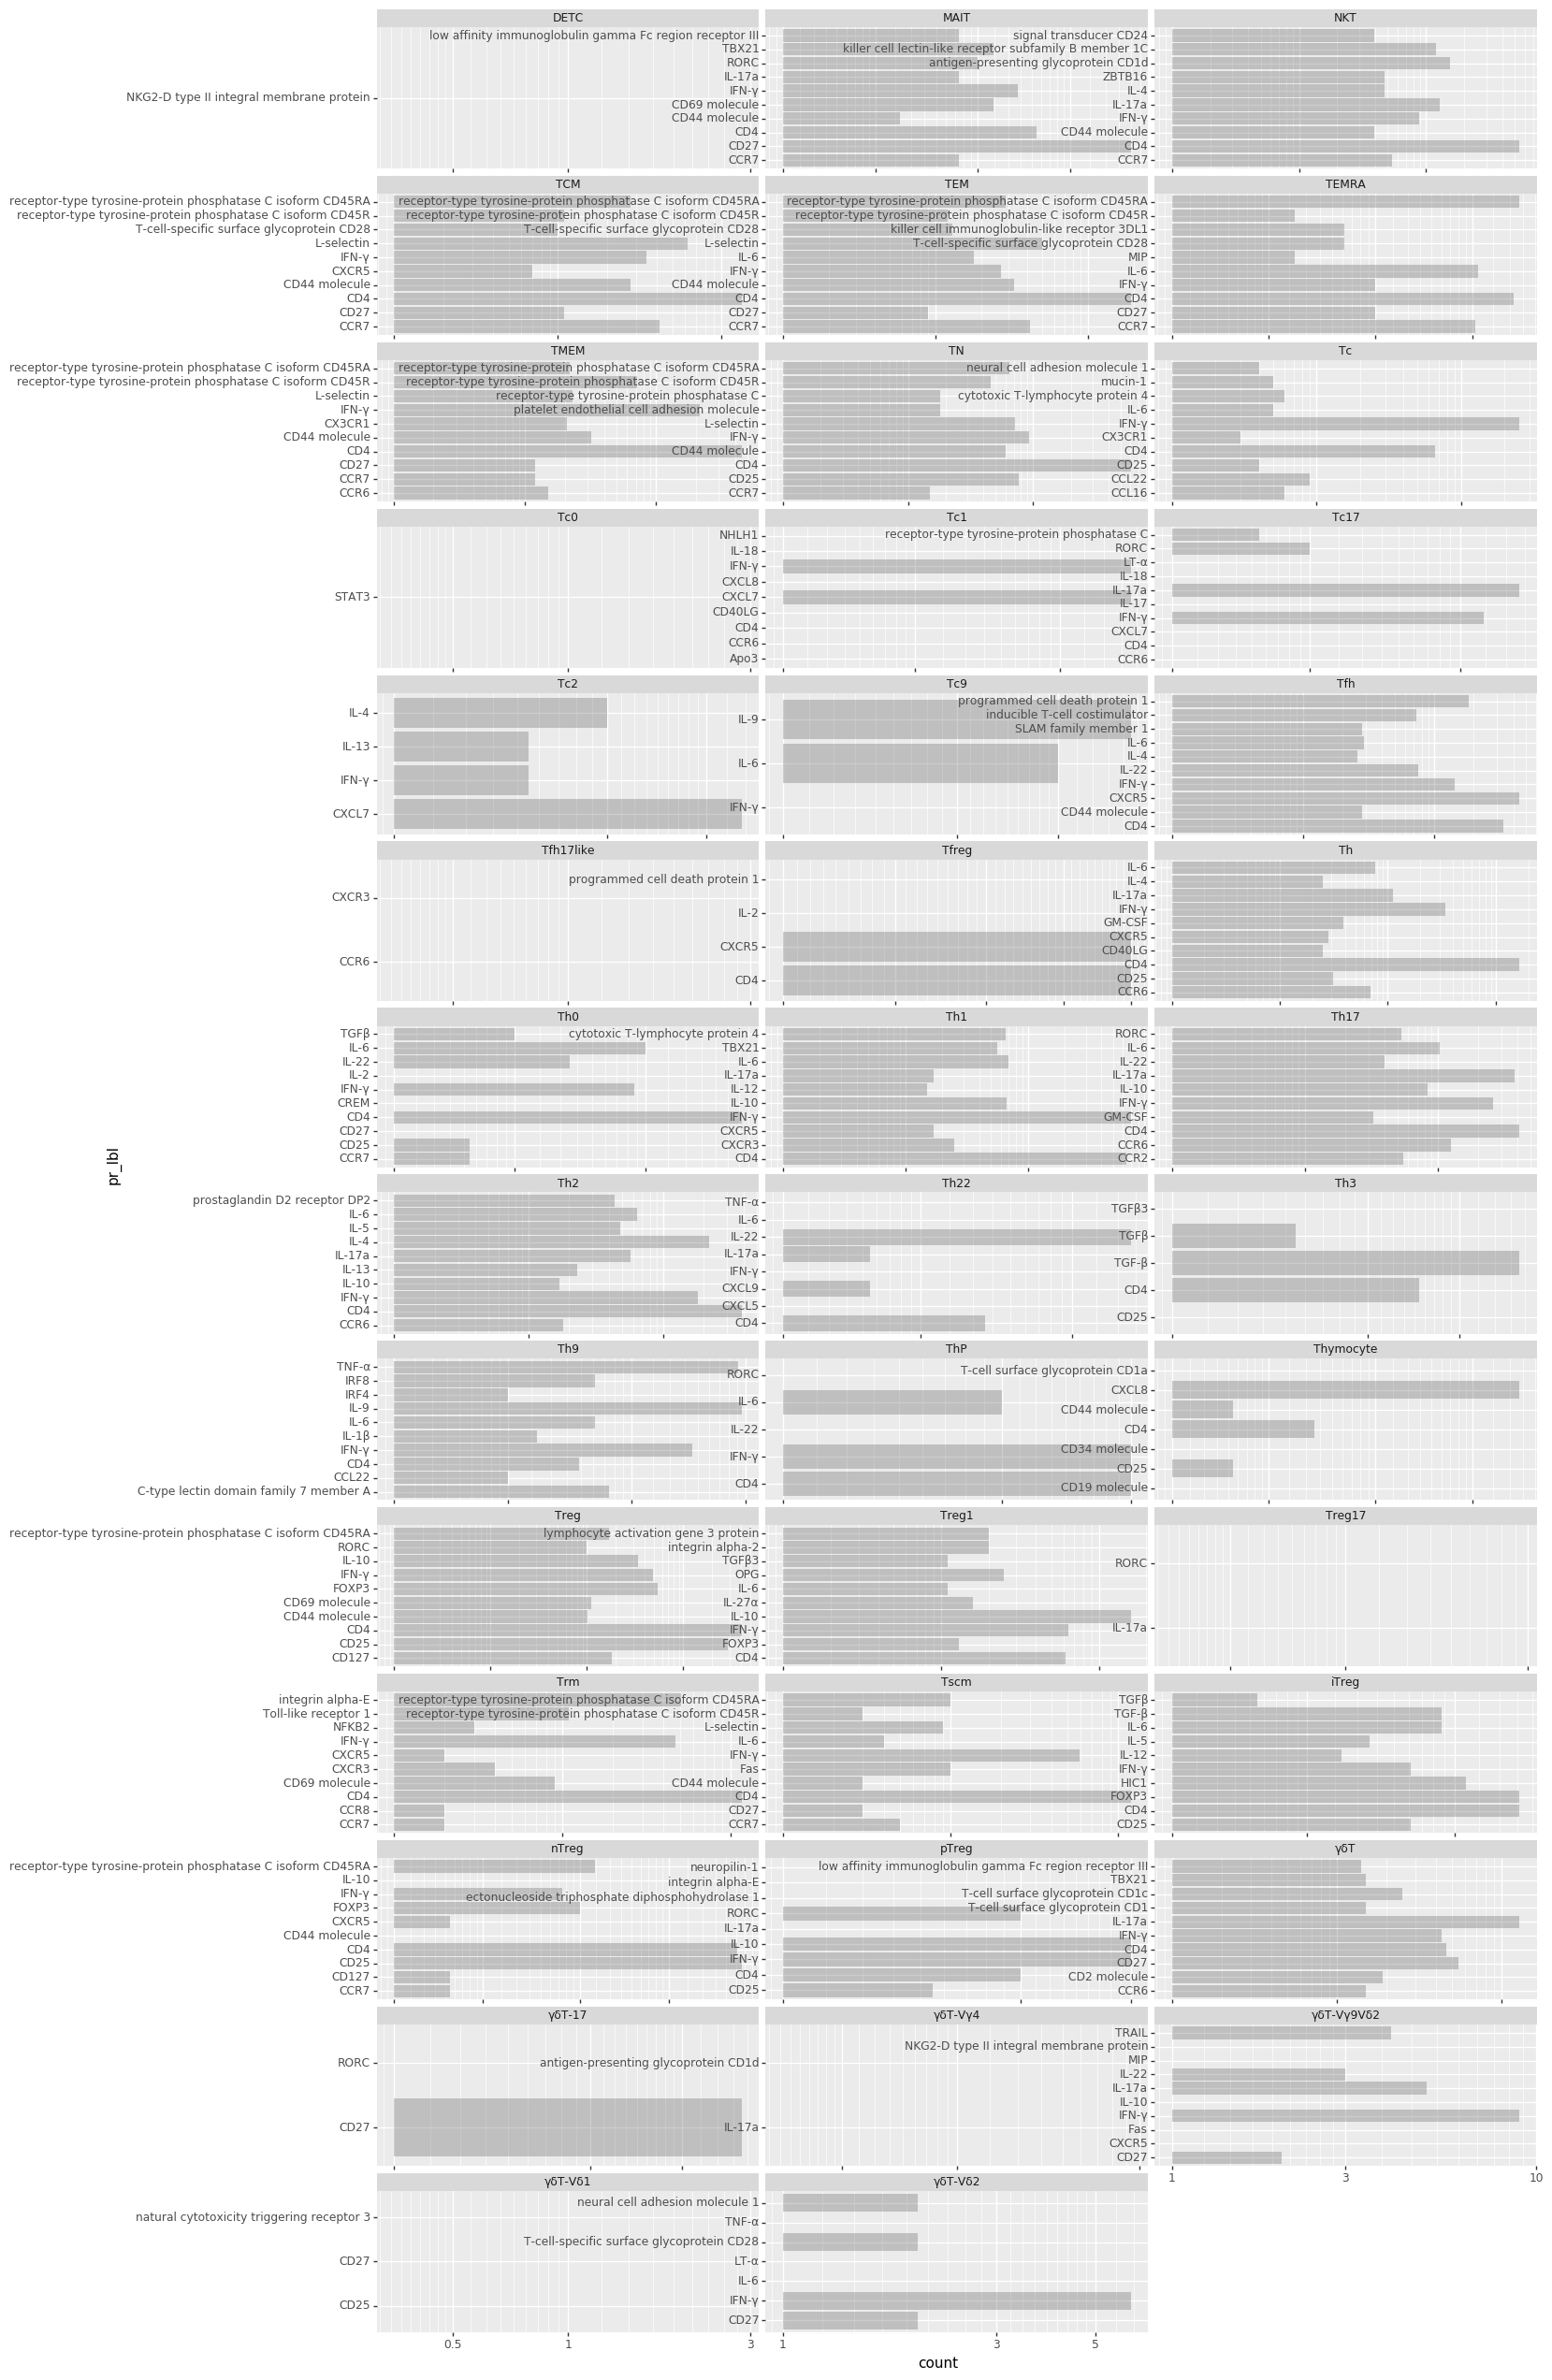

<ggplot: (-9223363292889551998)>

In [181]:
(
    pn.ggplot(
        df_ct_cts
        .groupby(['match_lbl', 'pr_lbl']).size().rename('count').reset_index()
        .groupby('match_lbl', group_keys=False).apply(lambda g: g.sort_values('count', ascending=False).head(10))
        ,
        pn.aes(x='pr_lbl', y='count')
    ) + 
    pn.geom_bar(stat='identity', alpha=.3) + 
    pn.facet_wrap('~match_lbl', scales='free', ncol=3) +
    pn.scale_y_log10() +
    pn.coord_flip() +
    pn.theme(figure_size=(24, 32))
)